In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os

import qtl.plot
import qtl.annotation
import style
annot = qtl.annotation.Annotation('/xchip/gtex/resources/gencode.v26.GRCh38.genes.gtf', verbose=False)

### Panel A

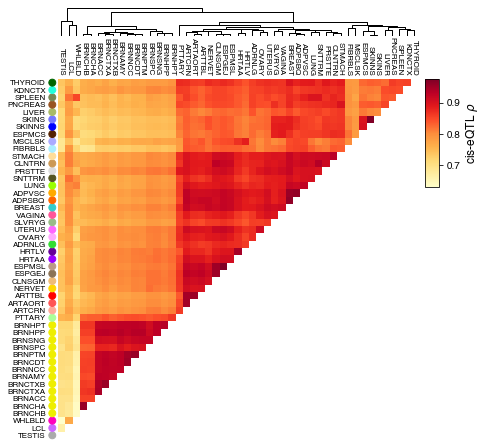

In [2]:
eqtl_corr_df = pd.read_csv('data/Fig6A_mashr_tissues.txt.gz',
                           sep='\t', index_col=0)
qtl.plot.clustermap(eqtl_corr_df.fillna(1), aw=5, ah=5, cmap=plt.cm.YlOrRd,
                    method='complete', metric='euclidean', optimal_ordering=False,
                    rotation=-90, ha='center', va='bottom', tri=True, clabel=r'cis-eQTL $\rho$',
                    origin='lower', db=1, dd=0.4, ds=0.6,
                    ch=1.5, cw=0.2, dc=0.1, fontsize=8, cfontsize=10,
                    label_colors=style.colors_df.set_index('tissue_abbrv').loc[eqtl_corr_df.columns, 'color_hex'])
plt.savefig('pdfs/Fig6A_eQTL_correlation_heatmap.pdf')

### Panel B

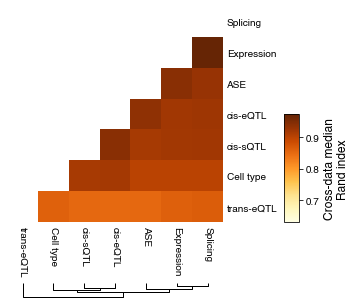

In [3]:
rand_df = pd.read_csv('data/Fig6B_clustering_similarity_median_rand.txt', sep='\t', index_col=0)
d = {'Cell Type':'Cell type', 'sQTL':'cis-sQTL'}
rand_df.rename(index=d, columns=d, inplace=True)

qtl.plot.clustermap(rand_df.fillna(1), aw=3, ah=3, cmap=plt.cm.YlOrBr, vmin=eqtl_corr_df.min().min(),
                    method='complete', metric='euclidean', optimal_ordering=True,
                    rotation=-90, ha='center', tri=True, clabel='Cross-data median\nRand index',
                    origin='lower', dendrogram_pos='bottom', db=0.5, dd=0.2, ds=0.85,
                    ch=1.5, cw=0.2, dc=0.85, fontsize=10, cfontsize=10, dl=0.25, dr=2)
plt.savefig('pdfs/Fig6B_Rand.pdf')

### Panel C

In [4]:
def load_df(df_path):
    df = pd.read_csv(df_path, sep='\t')
    df['gene'] = df['gene'].apply(lambda x: x.split(':')[-1])
    df['type'] = df['gene'].apply(lambda x: annot.gene_dict[x].type)
    df = df[df['type'].isin(['protein_coding', 'lincRNA'])]
    tissue_cols = df.columns[2:-1]
    df['n_na'] = df[tissue_cols].isnull().sum(1)
    return df

def bootstrap(v, bins, n=1000, pct=[2.5, 97.5]):
    """Confidence intervals (absolute difference relative to reference)"""
    x = np.array([np.histogram(np.random.choice(v, len(v), replace=True), bins)[0] for i in range(n)])
    x = x/x.sum(1, keepdims=True)
    x0 = np.histogram(v, bins)[0]
    x0 = x0/x0.sum()
    p = np.percentile(x, pct, axis=0) - x0
    return np.abs(p)

eqtl_df = load_df('data/Fig6C_all_top.z_lfsr.sig.pruned.txt.gz')
sqtl_df = load_df('data/Fig6C_sqtls.z_lfsr.sig.pruned.txt.gz')
tissue_cols = eqtl_df.columns[2:-2]

In [5]:
# histogram using only those eQTLs that are significant (LFSR < 0.05) in at least one tissue
xthreshold = 0.05
eqtl_df['n_sig'] = (eqtl_df[tissue_cols] < xthreshold).sum(1)
sqtl_df['n_sig'] = (sqtl_df[tissue_cols] < xthreshold).sum(1)

bins = np.arange(0,55,5)
bins[-1] = 49

eqtl_nsig_s = eqtl_df.loc[eqtl_df['n_sig']>0, 'n_sig']
eqtl_nsig_all_s = eqtl_df.loc[(eqtl_df['n_sig']>0) & (eqtl_df['n_na']==0), 'n_sig']
sqtl_nsig_s = sqtl_df.loc[sqtl_df['n_sig']>0, 'n_sig']
sqtl_nsig_all_s = sqtl_df.loc[(sqtl_df['n_sig']>0) & (sqtl_df['n_na']==0), 'n_sig']

hist_df = pd.DataFrame(np.c_[
    np.histogram(eqtl_nsig_s, bins)[0],
    np.histogram(eqtl_nsig_all_s, bins)[0],
    np.histogram(sqtl_nsig_s, bins)[0],
    np.histogram(sqtl_nsig_all_s, bins)[0],
], columns=['eQTLs', 'eQTLs tested in all tissues', 'sQTLs', 'sQTLs tested in all tissues'],
   index=['{}-{}'.format(i,j) for i,j in zip(bins[:-1]+1, bins[1:])])
hist_df /= hist_df.sum()

yerr = np.stack([
    bootstrap(eqtl_nsig_s, bins),
    bootstrap(eqtl_nsig_all_s, bins),
    bootstrap(sqtl_nsig_s, bins),
    bootstrap(sqtl_nsig_all_s, bins),
], axis=0)

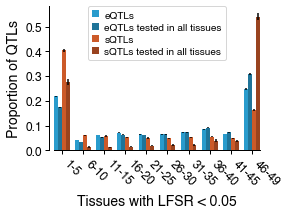

In [6]:
# plot
ax = qtl.plot.setup_figure(3,2,yspace=[0.75,0.25])
hist_df.plot.bar(yerr=yerr, width=0.75, color=style.qtl_color_s[['eqtl', 'eqtl_dark', 'sqtl', 'sqtl_dark']], ax=ax)
ax.legend(loc='upper center', handlelength=0.7, handletextpad=0.5, labelspacing=0.33, borderaxespad=0, fontsize=10)

qtl.plot.format_plot(ax, fontsize=12)
ax.spines['bottom'].set_smart_bounds(True)
ax.set_xticklabels(hist_df.index, rotation=-45, ha='left')
ax.set_xlabel('Tissues with LFSR < 0.05', fontsize=14, labelpad=6)
ax.set_ylabel('Proportion of QTLs', fontsize=14)
plt.savefig('pdfs/Fig6C_tissue_activity_LFSR.pdf')

### Panel D

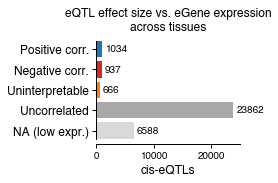

In [7]:
# Spearman correlation between eQTL effect size (aFC) and eGene expression level across tissues. 
# eQTL counts are shown for those not tested due to low expression level, tested but 
# without significant (FDR < 5%) correlation, a significant correlation but effect sizes crossed zero 
# which rendered the correlation uninterpretable, positively correlated, and negatively correlated.
cat_s = pd.read_csv('data/Fig6D_gtex_v8_all_eqtl_categories.txt', sep='\t', index_col=0, squeeze=True)

ax = qtl.plot.setup_figure(2,1.5, yspace=[0.75,0.5], xspace=[1.25, 0.5])
cat_s.to_frame().plot(ax=ax, kind='barh', stacked=False,
                      legend=False, width=0.8,
                      color=[[sns.color_palette("tab10")[0], 
                              sns.color_palette("tab10")[3], 
                              sns.color_palette("tab10")[1],
                              [0.66]*3, [0.85]*3]])
xlim = ax.get_xlim()
d = xlim[1]-xlim[0]
for k,i in enumerate(cat_s):
    ax.text(0.02*d+i, k, i, va='center', ha='left', fontsize=10)

ax.invert_yaxis()
qtl.plot.format_plot(ax, fontsize=12)
ax.tick_params(axis='x', labelsize=10)
ax.spines['left'].set_smart_bounds(True)
ax.set_xlabel('cis-eQTLs', fontsize=12)
ax.set_title('eQTL effect size vs. eGene expression\nacross tissues', fontsize=12)

plt.savefig('pdfs/Fig6D_eQTL_effect_corr.pdf')

### Panels E & F

In [8]:
eqtl_chrom_shared_df =    pd.read_csv('data/Fig6_pairwise_roadmap_analysis/eqtl_chrom_shared.txt', sep='\t', index_col=0)
eqtl_chrom_notshared_df = pd.read_csv('data/Fig6_pairwise_roadmap_analysis/eqtl_chrom_notshared.txt', sep='\t', index_col=0)
sqtl_chrom_shared_df =    pd.read_csv('data/Fig6_pairwise_roadmap_analysis/sqtl_chrom_shared.txt', sep='\t', index_col=0)
sqtl_chrom_notshared_df = pd.read_csv('data/Fig6_pairwise_roadmap_analysis/sqtl_chrom_notshared.txt', sep='\t', index_col=0)
eqtl_order_df =           pd.read_csv('data/Fig6_pairwise_roadmap_analysis/eqtl_order.txt', sep='\t', index_col=0)
sqtl_order_df =           pd.read_csv('data/Fig6_pairwise_roadmap_analysis/sqtl_order.txt', sep='\t', index_col=0)
sqtl_order_df = sqtl_order_df.loc[eqtl_order_df.index]

name_s = pd.read_csv('data/Fig6_pairwise_roadmap_analysis/name_map.txt',
                     sep='\t', header=None, index_col=0, squeeze=True)

for df in [eqtl_chrom_shared_df, eqtl_chrom_notshared_df, sqtl_chrom_shared_df, sqtl_chrom_notshared_df]:
    df.rename(index={i:name_s[i.split('|')[0]] for i in df.index}, inplace=True)

for df in [eqtl_order_df, sqtl_order_df]:
    df.rename(index={i:name_s[i] for i in df.index}, inplace=True)
    
# use full names from https://egg2.wustl.edu/roadmap/web_portal/chr_state_learning.html
chromhmm_df = pd.read_csv('data/Fig6_pairwise_roadmap_analysis/ChromHMM_15state_annot.txt', sep='\t')

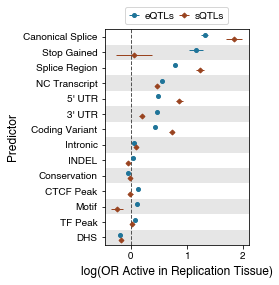

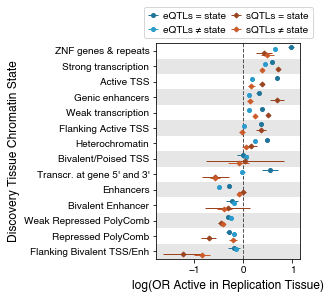

In [9]:
eargs = {'fmt':'.', 'ms':8,   'lw':1, 'clip_on':True, 'c':style.qtl_color_s['eqtl_dark'], 'label':'eQTLs'}
sargs = {'fmt':'D', 'ms':3.5, 'lw':1, 'clip_on':True, 'c':style.qtl_color_s['sqtl_dark'], 'label':'sQTLs'}
ax = qtl.plot.plot_effects([eqtl_order_df, sqtl_order_df], [eargs, sargs], 
                           xlabel='log(OR Active in Replication Tissue)',
                           ylabel='Predictor')
ax.legend(loc='lower center', ncol=2, columnspacing=0.5, 
          handlelength=1, handletextpad=0.5, bbox_to_anchor=(0.5,1))
plt.savefig('pdfs/Fig6E_sharing_pred_functional_annotations.pdf')

eargs1 = {'fmt':'.', 'ms':8,   'lw':1, 'clip_on':True, 'c':style.qtl_color_s['eqtl_dark'], 'label':'eQTLs = state'}
eargs2 = {'fmt':'.', 'ms':8,   'lw':1, 'clip_on':True, 'c':style.qtl_color_s['eqtl'],      'label':'eQTLs ≠ state'}
sargs1 = {'fmt':'D', 'ms':3.5, 'lw':1, 'clip_on':True, 'c':style.qtl_color_s['sqtl_dark'], 'label':'sQTLs = state'}
sargs2 = {'fmt':'D', 'ms':3.5, 'lw':1, 'clip_on':True, 'c':style.qtl_color_s['sqtl'],      'label':'sQTLs ≠ state'}

dfs = [eqtl_chrom_shared_df,
       eqtl_chrom_notshared_df,
       sqtl_chrom_shared_df,
       sqtl_chrom_notshared_df]
ax = qtl.plot.plot_effects([df.rename(index=chromhmm_df.set_index('MNEMONIC')['DESCRIPTION']) for df in dfs],
                           [eargs1, eargs2, sargs1, sargs2], 
                           yspace=[0.5,3,0.75],
                           xlabel='log(OR Active in Replication Tissue)',
                           ylabel='Discovery Tissue Chromatin State')
ax.legend(loc='lower center', ncol=2, columnspacing=0.5, 
          handlelength=1, handletextpad=0.5, bbox_to_anchor=(0.5,1))
plt.savefig('pdfs/Fig6F_sharing_pred_chromatin_state.pdf')